In [ ]:
# Making a directory for Kaggle API, changing its permissions and downloading a Kaggle competition dataset with it
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dog-breed-identification
!unzip -q dog-breed-identification.zip

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import os
import cv2
import warnings

In [2]:
# Warnings are disabled to remove noise from cell outputs
warnings.filterwarnings("ignore")

In [3]:
# Inspecting the labels
df = pd.read_csv("labels.csv")
print(df.shape)
df.head()

(10222, 2)


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

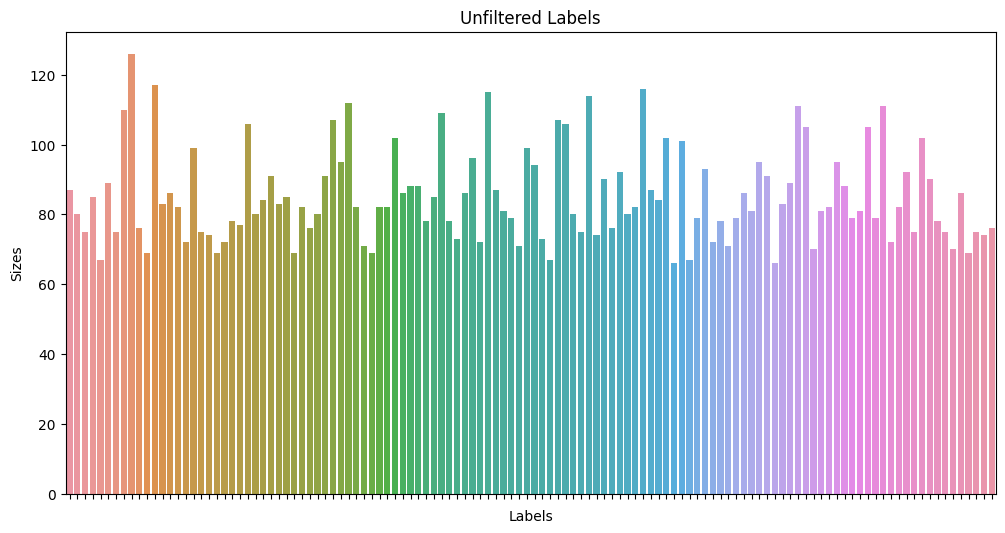

In [4]:
# Plotting the distribution of labels to visualize the dataset
# There's imbalance between labels which can lead to bias in model predictions
label_values = df["breed"].value_counts()
label_categories = {label: f'{i}' for i, label in enumerate(label_values.index, 1)}
df['breed_mapped'] = df['breed'].map(label_categories)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='breed_mapped', data=df)
plt.title('Unfiltered Labels')
plt.xlabel('Labels')
plt.ylabel('Sizes')

ax.set_xticklabels([])
plt.show()

In [5]:
# Labels with insufficient data are removed and only those with 100+ images are taken to avoid imbalances
top_labels = df["breed"].value_counts().nlargest(20).index.tolist()

filtered_df = df[df["breed"].isin(top_labels)]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df = filtered_df.drop("breed_mapped", axis=1)
print(filtered_df.shape)
filtered_df.head()

(2184, 2)


id               breed
0  003df8b8a8b05244b1d920bb6cf451f9             basenji
1  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
2  00693b8bc2470375cc744a6391d397ec         maltese_dog
3  00bee065dcec471f26394855c5c2f3de               cairn
4  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier

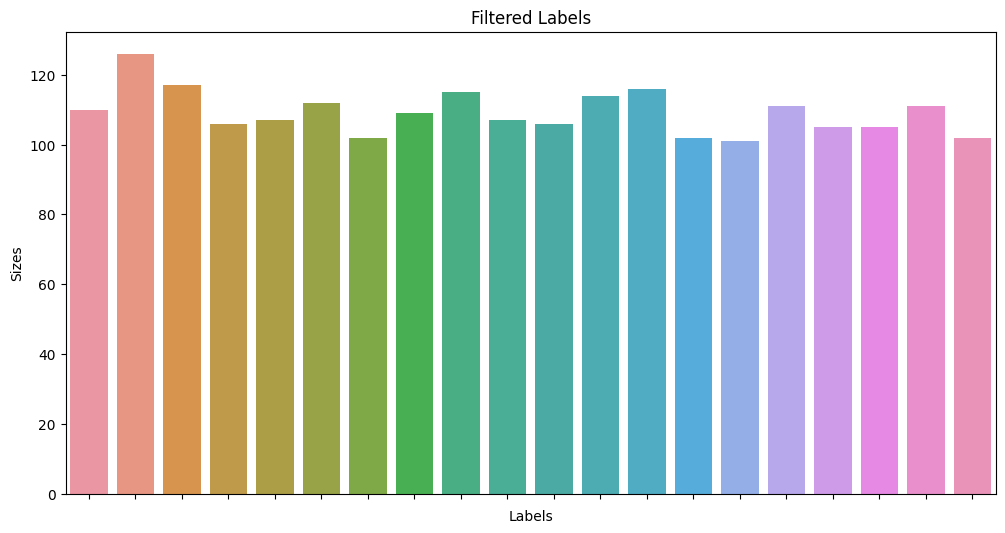

In [6]:
# Plotting the distribution of filtered labels to visualise the new dataset
label_values = filtered_df["breed"].value_counts()
label_categories = {label: f'L{i}' for i, label in enumerate(label_values.index, 1)}
filtered_df['breed_mapped'] = filtered_df['breed'].map(label_categories)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='breed_mapped', data=filtered_df)
plt.title('Filtered Labels')
plt.xlabel('Labels')
plt.ylabel('Sizes')

ax.set_xticklabels([])
plt.show()

In [7]:
# Specifying the file path for Google Colab
path = "/content/train"

# Defining a function for resizing images to a common size as neural network expects inputs of the same size
def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))
    return img

In [8]:
# Target size for all images is set to 128x128
refactor_size = 128

resized_images = [load_and_preprocess_image(os.path.join(path, f"{id}.jpg"), (refactor_size, refactor_size)) for id in filtered_df["id"]]

# Both resized images and labels are transformed into NumPy arrays as it's the expected data format and speeds up data processing speed
resized_images = np.asarray(resized_images)
labels = np.array(filtered_df["breed"])

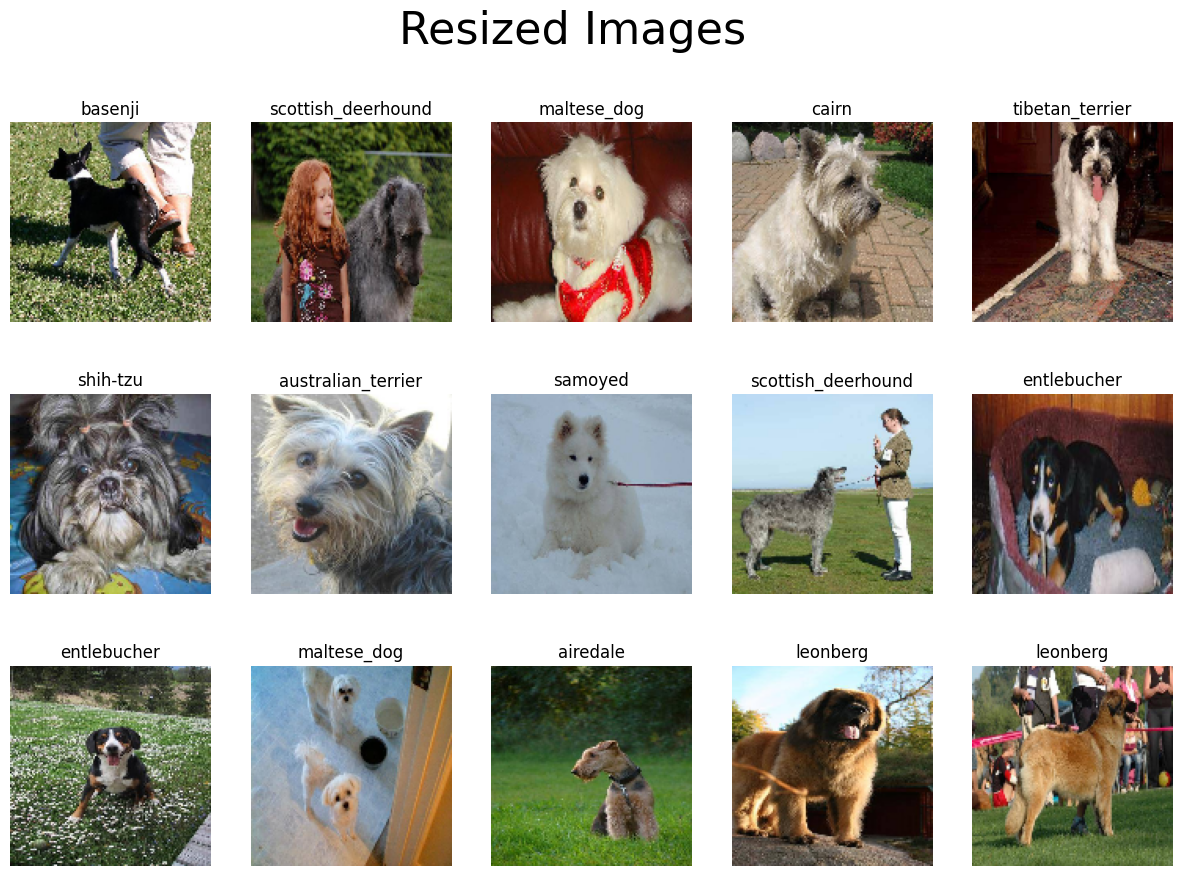

In [9]:
# Plotting resized images
fig1 = plt.figure(figsize=(15, 10))
fig1.suptitle('Resized Images', size=32)

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(resized_images[i])
    plt.title(filtered_df["breed"][i])
    plt.axis('Off')
    plt.grid(False)

plt.show()

In [10]:
# Augmenting resized images to introduce more variability
# Since number of images per breed is low, more aggressive data augmentation is applied to artificially increase the diversity of such data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomContrast(0.2)
])

# Augmented images are also transformed into a NumPy array for the same reasons
augmented_images = data_augmentation(resized_images)
augmented_images = np.asarray(augmented_images)

# Normalizing images to increase data processing speed, stabilize the learning process, increase the effectiveness of batch processing and improve generalization
# Normalization is applied after data augmentation to ensure a consistent pixel scale across augmentations, as such augmentations can alter pixel values
augmented_images = augmented_images / 255.0

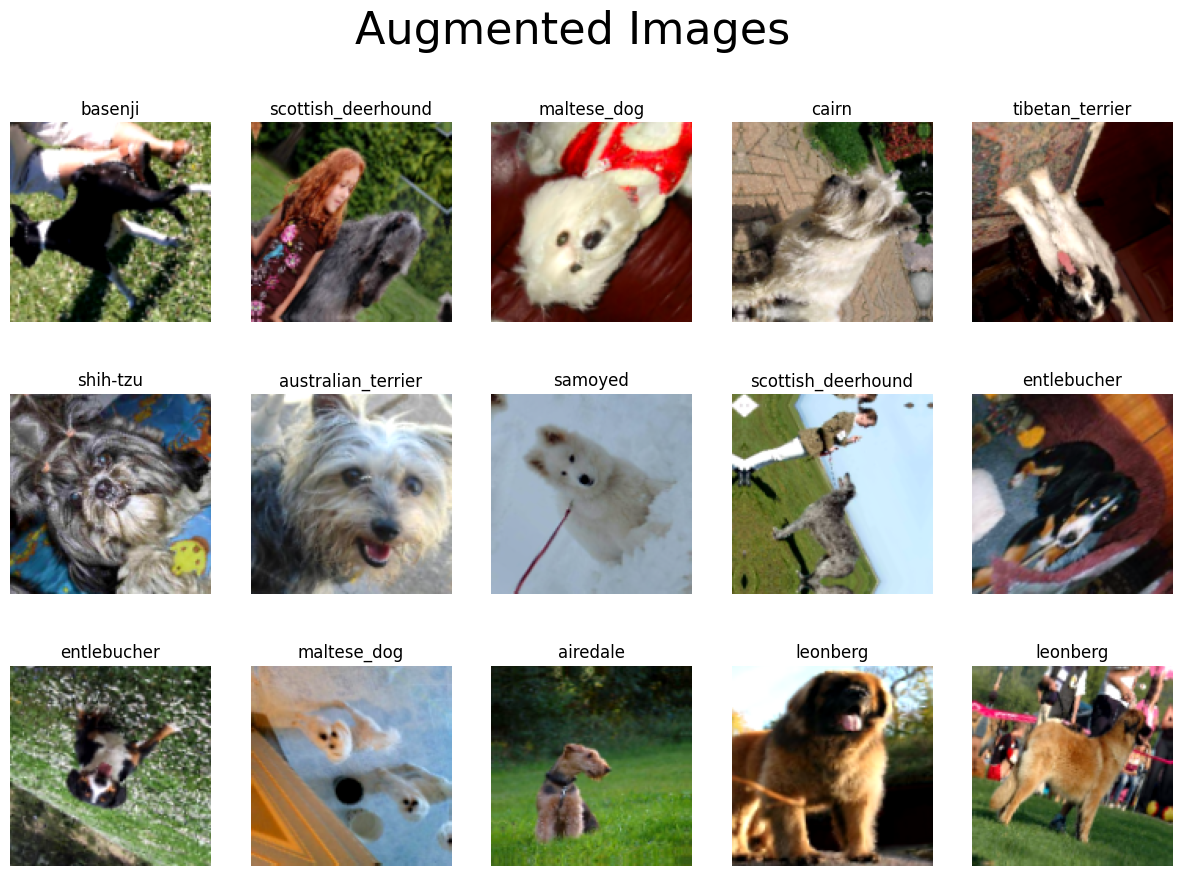

In [11]:
# Plotting augmented images to check whether they still accurately represent real life dogs
fig1 = plt.figure(figsize=(15, 10))
fig1.suptitle('Augmented Images', size=32)

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(filtered_df["breed"][i])
    plt.axis('Off')
    plt.grid(False)

plt.show()

In [12]:
# A random seed is used in train-test split to make accurate and consistent comparisons possible in the tuning process
X_train, X_test, y_train, y_test = train_test_split(augmented_images, labels, random_state=42)
print(X_train.shape, y_train.shape)

(1638, 128, 128, 3) (1638,)


In [13]:
# Training data is shuffled to introduce more randomness and to prevent bias that may result from the model learning the order of trainig data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [14]:
# Labels are encoded for data processing
# Labels are encoded based on the patterns in y_train and the same patterns are applied to y_test for consistent encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [15]:
# Relu is used as the activation function across all hidden layers as it leads to better convergence
# Softmax is used as the activation function of the output layer because it's suitable for multi class classification problems
model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    data_augmentation,

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])

In [16]:
# Checkpoints are used to keep track of model accuracy and save the best performing model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [17]:
# Early stopping is used to prevent overfitting and prevent waste of computer resources
# A patience threshold of 10 is used because the dataset is relatively small and learns patterns more quickly
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [18]:
# Sparse categorical crossentropy is used as the loss function because it's suitable for multi class classification tasks
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# The model is set to run for a relatively high number of epochs to give early stopping enough room to trigger
# During each epoch a different batch of data (of size 128) is used for faster training, higher efficieny, better convergence and increased generalization
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[checkpoint, early_stopping], batch_size=128)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 3.0205 - accuracy: 0.0495
Epoch 1: val_accuracy improved from -inf to 0.04212, saving model to best_model.h5
13/13 [==============================] - 9s 150ms/step - loss: 3.0205 - accuracy: 0.0495 - val_loss: 2.9961 - val_accuracy: 0.0421
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.9960 - accuracy: 0.0521
Epoch 2: val_accuracy improved from 0.04212 to 0.05495, saving model to best_model.h5
13/13 [==============================] - 1s 66ms/step - loss: 2.9960 - accuracy: 0.0507 - val_loss: 2.9954 - val_accuracy: 0.0549
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 2.9946 - accuracy: 0.0501
Epoch 3: val_accuracy improved from 0.05495 to 0.05678, saving model to best_model.h5
13/13 [==============================] - 1s 66ms/step - loss: 2.9947 - accuracy: 0.0507 - val_loss: 2.9940 - val_accuracy: 0.0568
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 

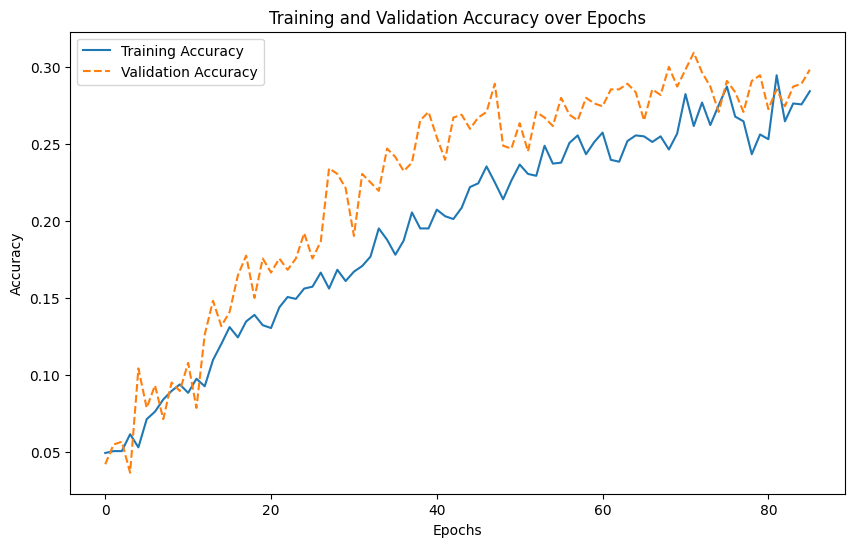

In [20]:
# Plotting the training and validation accuracies to assess convergence and check for overfitting
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

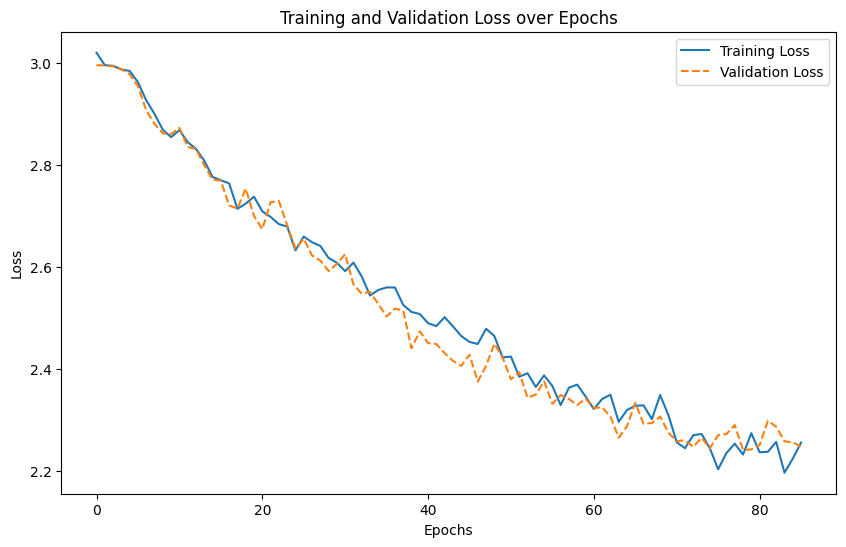

In [21]:
# Doing the same for losses to get a more accurate picture of the training process
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
# Best performing model is saved separetly
best_model = models.load_model('best_model.h5')

In [23]:
# Model is tested to get its highest accuracy
test_loss, best_test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

18/18 - 0s - loss: 2.2599 - accuracy: 0.3095 - 474ms/epoch - 26ms/step

Best Test Accuracy: 0.3095238208770752


In [24]:
# Predictions are made with the model
best_predictions = best_model.predict(X_test)
best_predicted_classes = np.argmax(best_predictions, axis=1)

18/18 [==============================] - 0s 7ms/step


In [25]:
# List of labels is taken
unique_labels = filtered_df["breed"].unique().tolist()

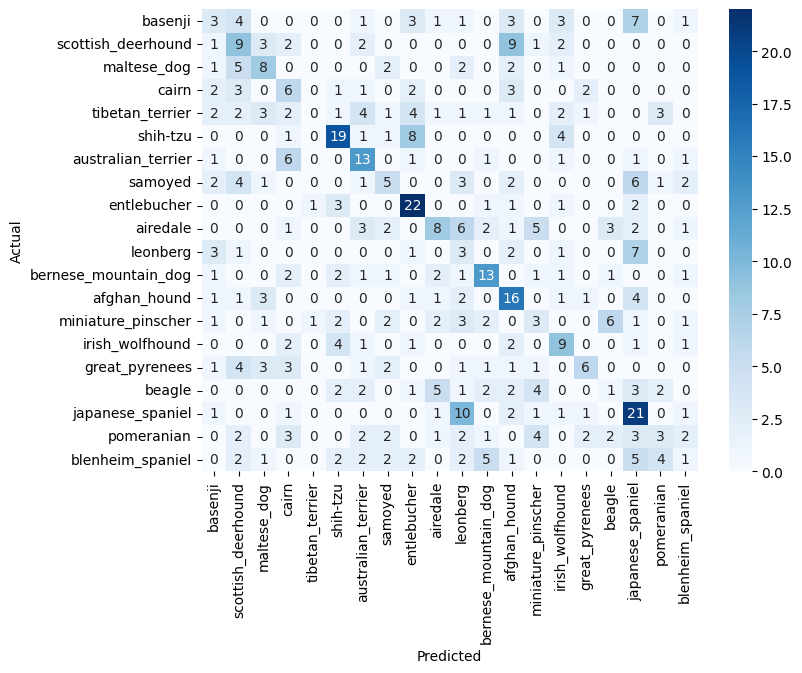

In [26]:
# A heatmap is generated to visualize the confusion matrix for performance evaluation
best_cm = confusion_matrix(y_test, best_predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

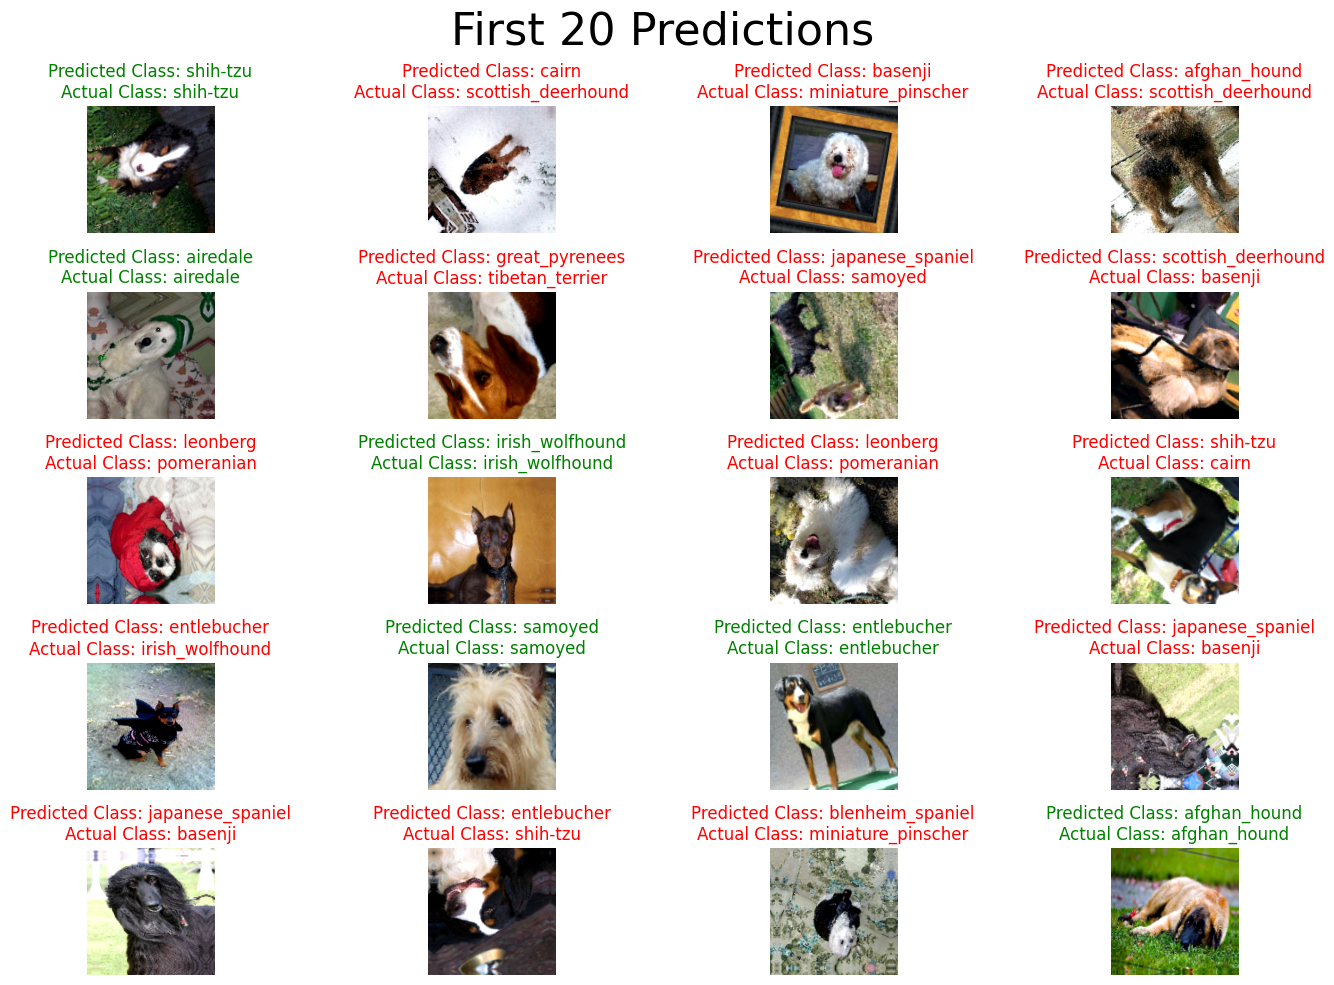

In [27]:
# A subset of predictions are visualized to further assess the performance
plt.figure(figsize=(15, 10))
plt.suptitle('First 20 Predictions', size=32)

for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i])
    predicted_class_label = unique_labels[best_predicted_classes[i]]
    actual_class_label = unique_labels[y_test[i]]

    if best_predicted_classes[i] == y_test[i]:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f'Predicted Class: {predicted_class_label}\nActual Class: {actual_class_label}'
    plt.title(title, color=title_color)
    plt.axis('off')
    plt.grid(False)

plt.tight_layout()
plt.show()

In [28]:
# Cross validating the model to confirm its performance

# Shuffling the augmented images for increased randomness
augmented_images, labels = shuffle(augmented_images, labels, random_state=42)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Number of folds for cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Variables for performance metrics
all_accuracies = []
all_losses = []
all_val_losses = []

for fold, (train_index, val_index) in enumerate(skf.split(augmented_images, encoded_labels), 1):
    print(f"Training on Fold {fold}...")

    X_train, X_val = augmented_images[train_index], augmented_images[val_index]
    y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]

    model = models.Sequential([
        tf.keras.Input(shape=(128, 128, 3)),
        data_augmentation,
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(20, activation='softmax')
    ])

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, callbacks=[early_stopping], batch_size=128)

    # Evaluation of the model's accuracy and loss
    _, accuracy = model.evaluate(X_val, y_val)
    all_accuracies.append(accuracy)

    val_loss = history.history['val_loss']
    all_losses.append(val_loss)
    all_val_losses.append(val_loss[-1])

Training on Fold 1...
Epoch 1/75
14/14 [==============================] - 5s 161ms/step - loss: 3.0071 - accuracy: 0.0555 - val_loss: 2.9952 - val_accuracy: 0.0503
Epoch 2/75
14/14 [==============================] - 1s 59ms/step - loss: 2.9946 - accuracy: 0.0618 - val_loss: 2.9944 - val_accuracy: 0.0595
Epoch 3/75
14/14 [==============================] - 1s 63ms/step - loss: 2.9949 - accuracy: 0.0550 - val_loss: 2.9937 - val_accuracy: 0.0686
Epoch 4/75
14/14 [==============================] - 1s 57ms/step - loss: 2.9902 - accuracy: 0.0612 - val_loss: 2.9865 - val_accuracy: 0.0572
Epoch 5/75
14/14 [==============================] - 1s 63ms/step - loss: 2.9703 - accuracy: 0.0807 - val_loss: 2.9496 - val_accuracy: 0.0847
Epoch 6/75
14/14 [==============================] - 1s 64ms/step - loss: 2.9217 - accuracy: 0.0744 - val_loss: 2.9087 - val_accuracy: 0.0892
Epoch 7/75
14/14 [==============================] - 1s 57ms/step - loss: 2.8949 - accuracy: 0.0893 - val_loss: 2.9369 - val_accurac

In [29]:
# Overall performance and loss
print(f"\nAverage Accuracy across {num_folds} folds: {sum(all_accuracies) / num_folds:.2%}")
print(f"\nAverage Validation Loss across {num_folds} folds: {np.mean(all_val_losses)}")


Average Accuracy across 5 folds: 28.02%

Average Validation Loss across 5 folds: 2.2701213359832764
